In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/alzheimers-disease'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzheimers-disease/Non_Demented/non_798.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_2592.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_318.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_207.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_2248.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_2733.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_2791.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_2393.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_106.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_2986.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_707.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_756.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_1199.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_1758.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_2615.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_1781.jpg
/kaggle/input/alzheimers-disease/Non_Demented/non_2042.jpg
/ka

In [2]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
import random
import cv2
import warnings
warnings.filterwarnings("ignore")

2024-07-23 16:51:21.483133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 16:51:21.483278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 16:51:21.780003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Classes we have in our data set.
total_classes = os.listdir("/kaggle/input/alzheimers-disease")
total_classes
# /kaggle/input/alzheimers-disease-dataset

['Non_Demented', 'Mild_Demented', 'Moderate_Demented', 'Very_Mild_Demented']

In [4]:
# Total number of images per class.
images_path = Path("/kaggle/input/alzheimers-disease")

for c in total_classes:
  print(f'* {c}', '=',len(os.listdir(os.path.join(images_path, c))), 'images')

* Non_Demented = 3200 images
* Mild_Demented = 896 images
* Moderate_Demented = 64 images
* Very_Mild_Demented = 2240 images


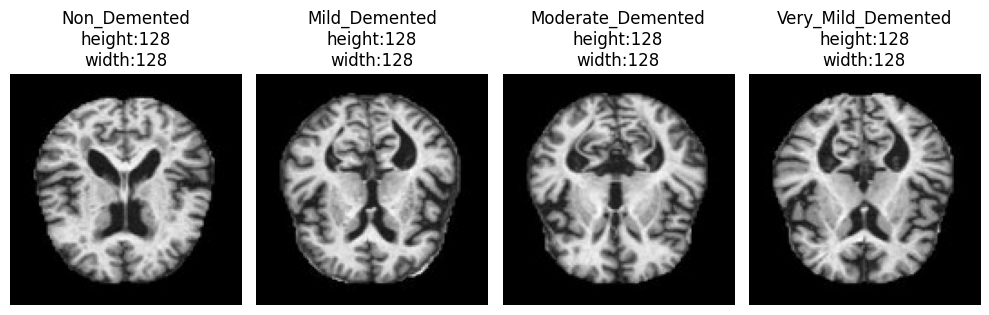

In [5]:
# Let's display 1 image per class.

fig,ax = plt.subplots(1,4,figsize=(10,4))
ax = ax.flat
for i,c in enumerate(total_classes):
  img_total_class = list(Path(os.path.join(images_path, c)).glob("*.jpg"))
  img_selected = random.choice(img_total_class)
  img_BGR = cv2.imread(str(img_selected))
  img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)
  height,width,channel = img_RGB.shape
  ax[i].imshow(img_RGB)
  ax[i].set_title(f"{img_selected.parent.stem}\nheight:{height}\nwidth:{width}")
  ax[i].axis("off")

fig.tight_layout()
fig.show()

In [6]:
batch_size = 32
img_height = 227
img_width = 227

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size = (img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    images_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


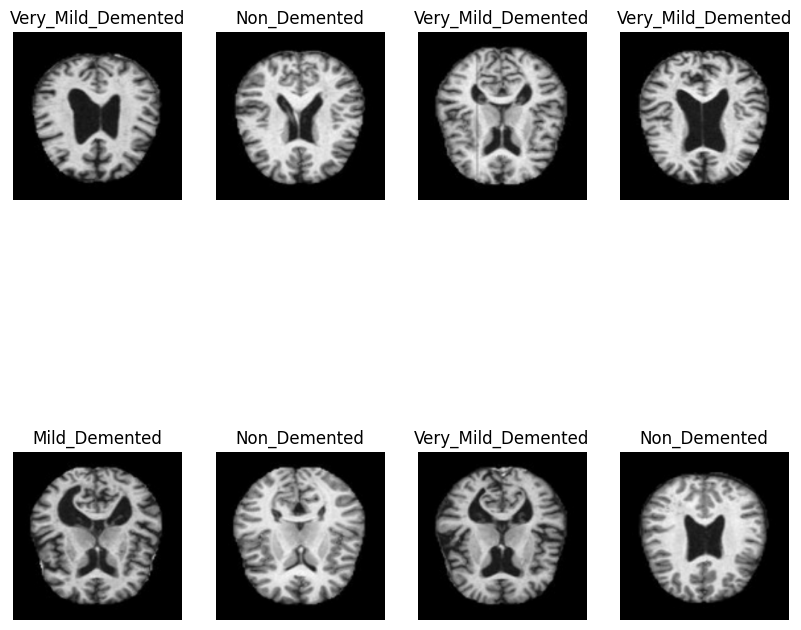

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 227, 227, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardizing the dataset**

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in '[0,1]'

print(np.min(first_image), np.max(first_image))

0.0 0.9945052


**Creating the model**

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the number of output classes
num_classes = len(class_names)

# Initialize the model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227, 227, 3), kernel_size=(11, 11), strides=(4, 4), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# Flatten the model
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# 2nd Fully Connected Layer
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))


In [22]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 29, 29, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 29, 29, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 15, 15, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 15, 15, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    67,112,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,657,860 (334.39 MB)

 Trainable params: 87,657,860 (334.39 MB)

 Non-trainable params: 0 (0.00 B)

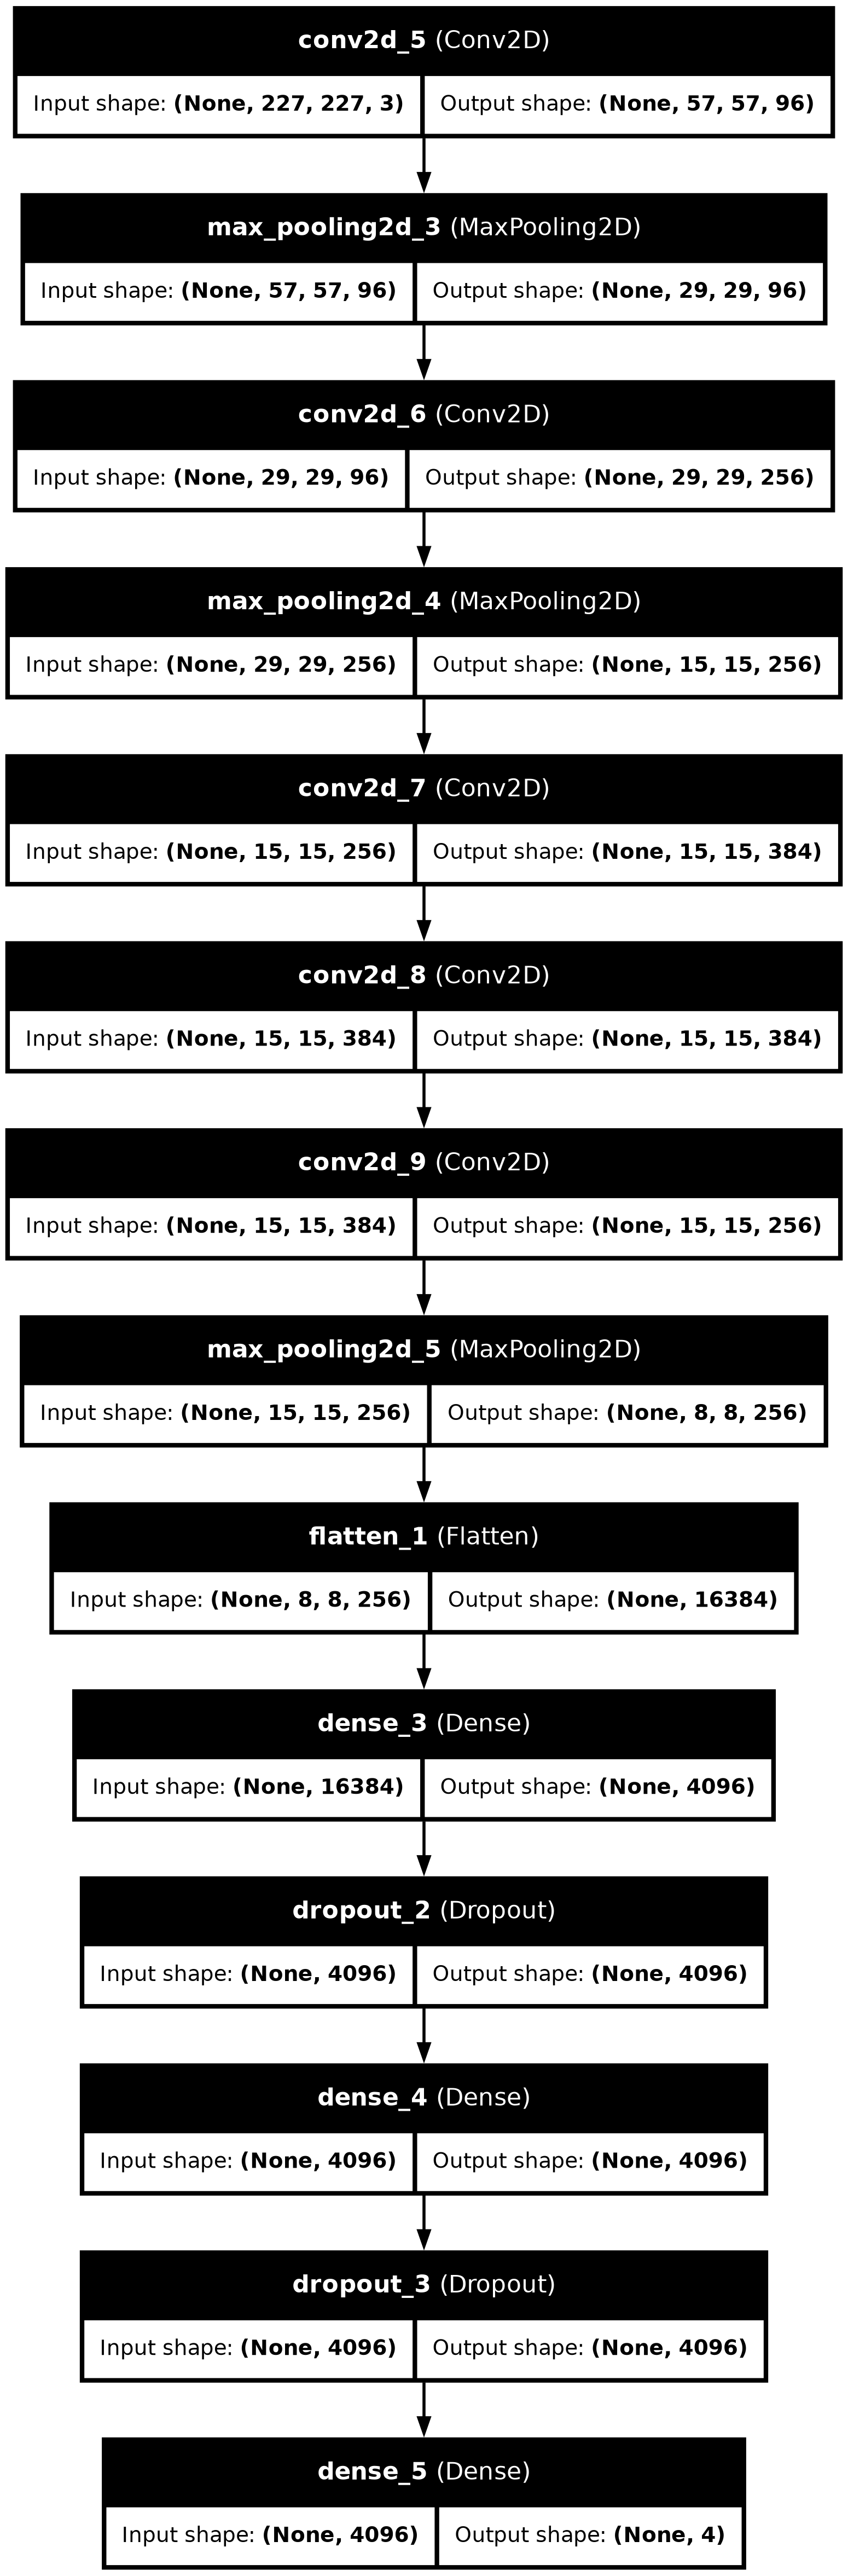

In [24]:
from tensorflow.keras.utils import plot_model
# Save the model summary as an image
plot_model(model, to_file='AlexNet_model_summary_before_Data_Aug.png', show_shapes=True, show_layer_names=True)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [41]:
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/100
  2/160 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.2500 - loss: 523.4819

W0000 00:00:1721754696.934626     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4648 - loss: 62.8542

W0000 00:00:1721754706.876148     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.4649 - loss: 62.5530 - val_accuracy: 0.5391 - val_loss: 1.0213
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.4855 - loss: 1.0361 - val_accuracy: 0.5109 - val_loss: 1.0265
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.5046 - loss: 1.0324 - val_accuracy: 0.5109 - val_loss: 1.0262
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.4975 - loss: 1.0358 - val_accuracy: 0.5109 - val_loss: 1.0261
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4964 - loss: 1.0347 - val_accuracy: 0.5109 - val_loss: 1.0260
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4997 - loss: 1.0406 - val_accuracy: 0.5109 - val_loss: 1.0296
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4993 - loss: 1.0392 - val_accuracy: 0.5109 - val_loss: 1.0255
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.5085 - loss: 1.0350 - val

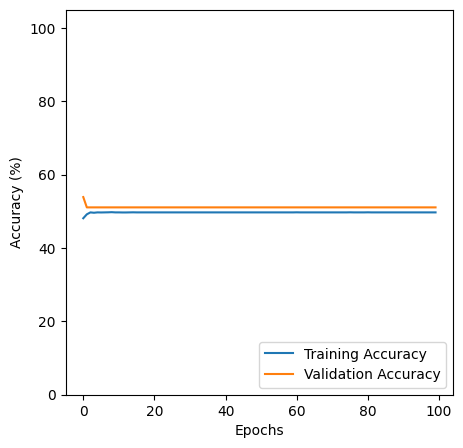

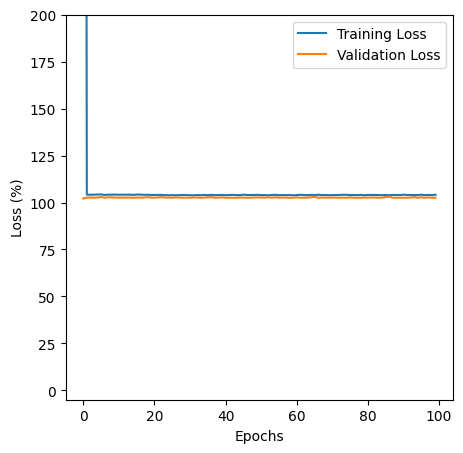

In [42]:
import matplotlib.pyplot as plt

acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]

loss = [b * 100 for b in history.history['loss']]
val_loss = [b * 100 for b in history.history['val_loss']]

epochs_range = range(len(acc))  # Use the length of the accuracy list

# Plot Training and Validation Accuracy
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim([0, 105])  # Set the y-axis limit from 0 to 100
# Save the accuracy plot
plt.savefig('AlexNet_100_training_validation_accuracy_before_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss (%)')
plt.xlabel('Epochs')
plt.ylim([-5, 200])
# Save the loss plot
plt.savefig('AlexNet_100_training_validation_loss_before_Data_Aug.png')  # You can change the path and filename as needed
plt.show()


In [43]:
model.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5194 - loss: 1.0106


[1.0256272554397583, 0.510937511920929]

In [44]:
model.evaluate(train_ds)

160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4808 - loss: 1.0440


[1.0378830432891846, 0.49726563692092896]

**Augmentation**

In [45]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),

    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

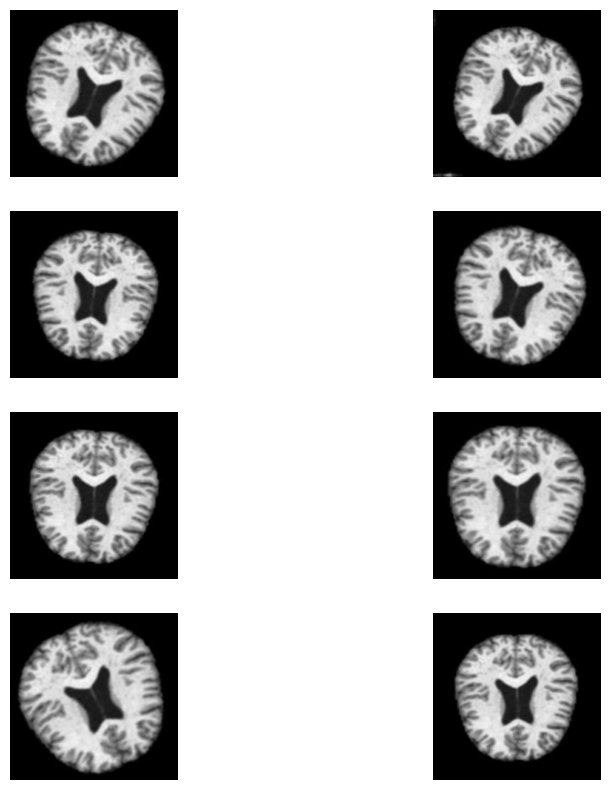

In [46]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(8):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4,2, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Add a dropout layer**

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the number of output classes
num_classes = len(class_names)

# Initialize the model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227, 227, 3), kernel_size=(11, 11), strides=(4, 4), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(Dropout(0.2))

# Flatten the model
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# 2nd Fully Connected Layer
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))


In [48]:
model.compile(optimizer="adam",
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])

In [49]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 57, 57, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 29, 29, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 29, 29, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 15, 15, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 15, 15, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 15, 15, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4096)           │    67,112,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,657,860 (334.39 MB)

 Trainable params: 87,657,860 (334.39 MB)

 Non-trainable params: 0 (0.00 B)

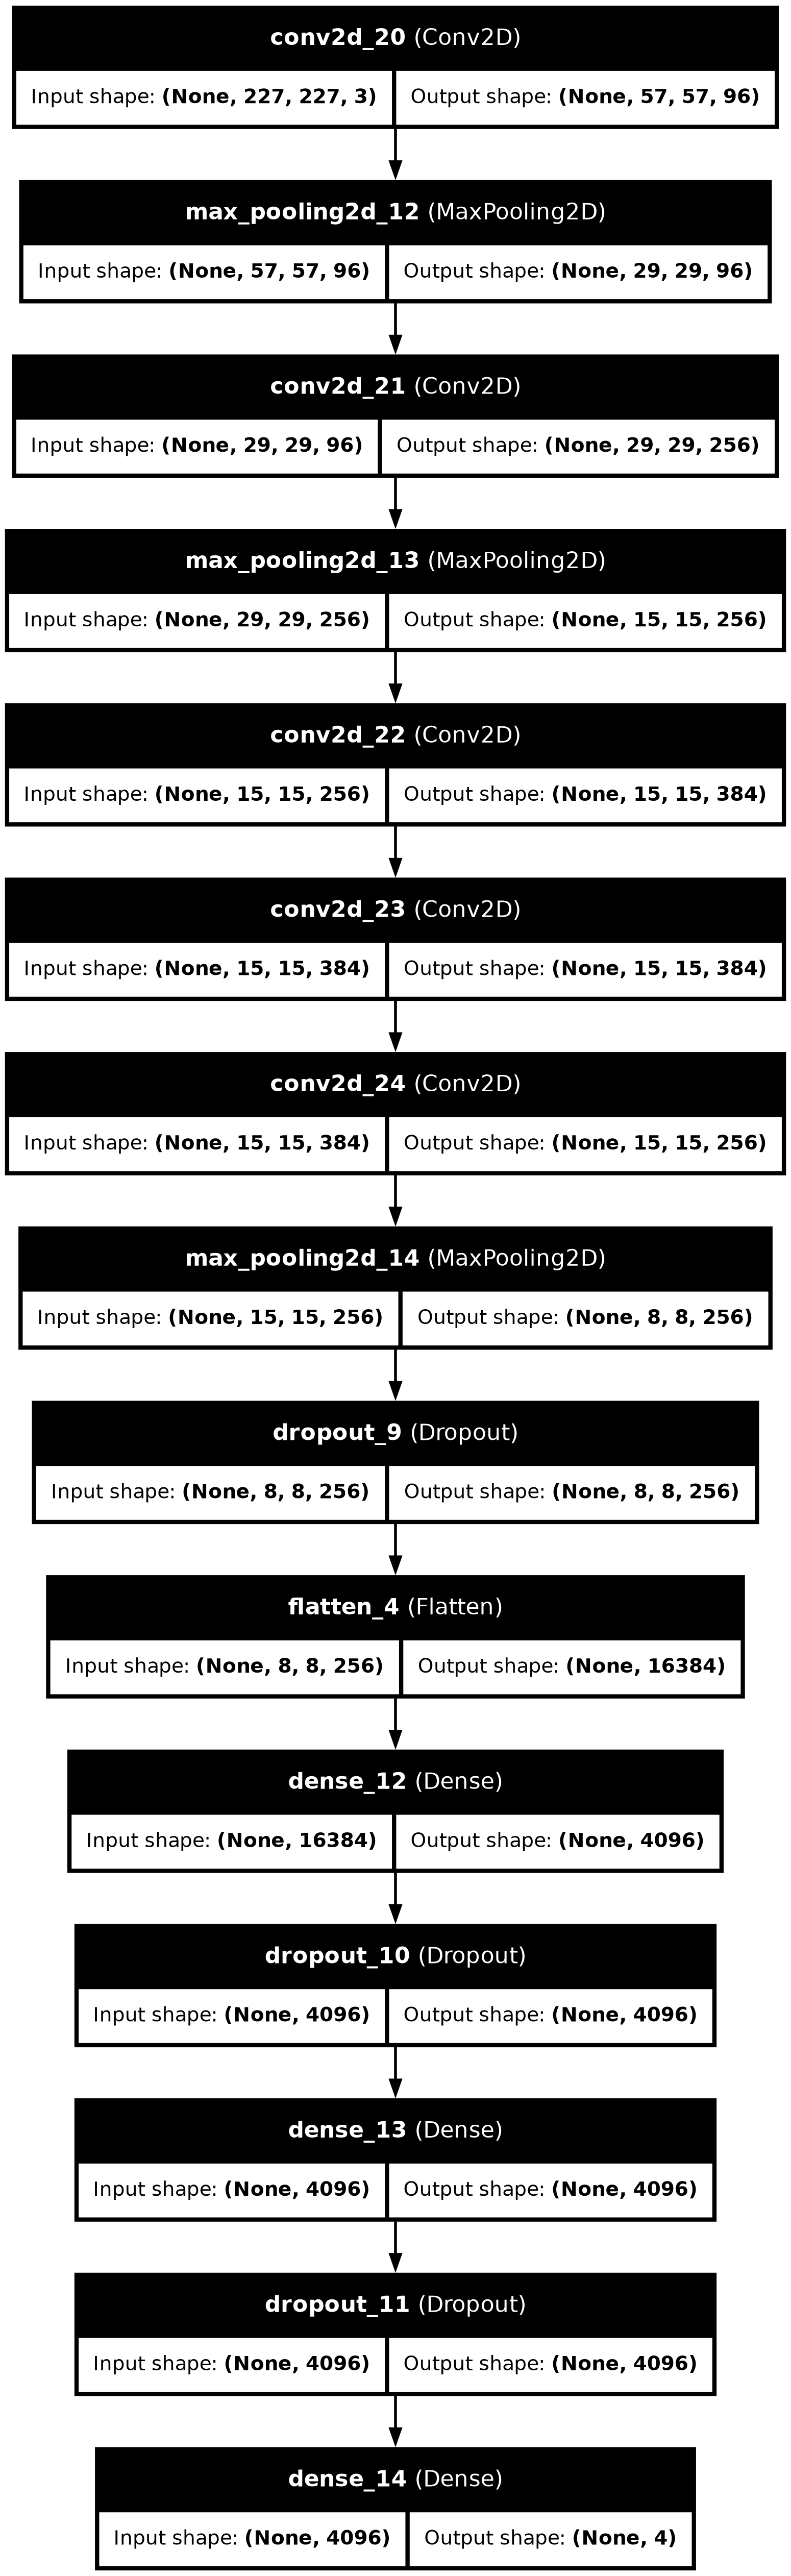

In [40]:
from tensorflow.keras.utils import plot_model
# Save the model summary as an image
plot_model(model, to_file='AlexNet_100_model_summary_after_Data_Aug.png', show_shapes=True, show_layer_names=True)

In [50]:
epochs = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/100
  2/160 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.1797 - loss: 231.4465

W0000 00:00:1721755894.669187     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4401 - loss: 29.9615

W0000 00:00:1721755904.526055     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.4403 - loss: 29.8209 - val_accuracy: 0.5437 - val_loss: 1.0257
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.4957 - loss: 1.0277 - val_accuracy: 0.5508 - val_loss: 1.0035
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.5323 - loss: 1.0081 - val_accuracy: 0.5516 - val_loss: 0.9865
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.5087 - loss: 1.0212 - val_accuracy: 0.5625 - val_loss: 0.9826
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.5225 - loss: 1.0284 - val_accuracy: 0.5633 - val_loss: 0.9851
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.5257 - loss: 1.0094 - val_accuracy: 0.5281 - val_loss: 0.9970
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.5379 - loss: 1.0029 - val_accuracy: 0.5109 - val_loss: 1.0356
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4882 - loss: 1.0553 - val

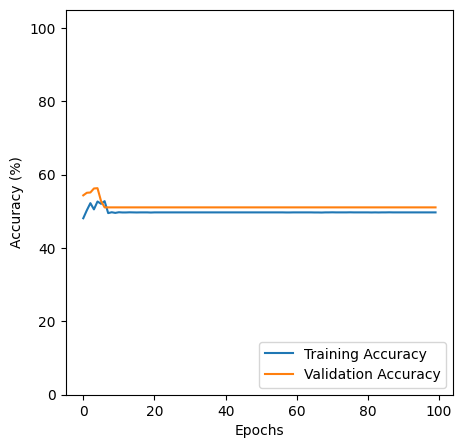

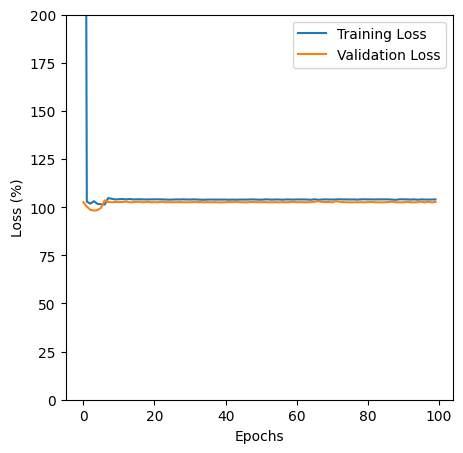

In [52]:
import matplotlib.pyplot as plt

acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]

loss = [b * 100 for b in history.history['loss']]
val_loss = [b * 100 for b in history.history['val_loss']]

epochs_range = range(len(acc))

# Plot Training and Validation Accuracy
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title("Training and Validation Accuracy")
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim([0, 105])  # Set the y-axis limit from 0 to 100
# Save the accuracy plot
plt.savefig('CNN_100_training_validation_accuracy_after_Data_Aug.png')  # You can change the path and filename as needed
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
plt.ylabel('Loss (%)')
plt.xlabel('Epochs')
plt.ylim([0, 200])
# Save the loss plot
plt.savefig('CNN_100_training_validation_loss_after_Data_Aug.png')  # You can change the path and filename as needed
plt.show()


In [53]:
model.evaluate(train_ds)

160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4992 - loss: 1.0411


[1.0388380289077759, 0.49726563692092896]

In [54]:
model.evaluate(val_ds)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5194 - loss: 1.0128


[1.0274776220321655, 0.510937511920929]